In [3]:
!git clone https://github.com/atharvajoshi10/quantized-lag-llama

Cloning into 'quantized-lag-llama'...


In [25]:
!move quantized-lag-llama\lag_llama .\lag_llama

        1 dir(s) moved.


In [7]:
!move quantized-lag-llama\data .\data

        1 dir(s) moved.


In [8]:
!move quantized-lag-llama\gluon_utils .\gluon_utils

        1 dir(s) moved.


In [ ]:
%%capture
%pip install -r requirements.txt

In [1]:
from itertools import islice
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.pandas import PandasDataset
import pandas as pd

c:\Python\Lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [11]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
df = pd.read_csv("electricity.csv", index_col=0, parse_dates=True)

In [16]:
df["item_id"] = "MT_001"
df.rename(columns={"MT_001": "target"}, inplace=True)

In [19]:
df = df[["target", "item_id"]]

In [20]:
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

C:\Users\athu2\AppData\Local\Temp\ipykernel_42940\29596338.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('float32')


In [21]:
df.head()

,target,item_id
2012-01-02,1025.380737,MT_001
2012-01-03,1040.609131,MT_001
2012-01-04,1093.908569,MT_001
2012-01-05,1351.522827,MT_001
2012-01-06,1331.218262,MT_001


In [22]:
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

In [23]:
backtest_dataset = dataset
prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cpu") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [24]:
from lag_llama.gluon.quantized_estimator import QuantizedLagLlamaEstimator

In [25]:
def get_quantized_models(prediction_length, device):
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = QuantizedLagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32, # Should not be changed; this is what the released Lag-Llama model was trained with

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()

    return estimator, lightning_module

In [26]:
q_estimator, q_lightning_module = get_quantized_models(prediction_length, device)
q_lightning_module.model.qconfig = torch.ao.quantization.default_qconfig
q_lightning_module.model = torch.ao.quantization.prepare(q_lightning_module.model)
q_lightning_module.model

QuantizedLagLlamaModel(
  (param_proj): QuantizedPtArgProj(
    (proj): ModuleList(
      (0-2): 3 x Linear(
        in_features=144, out_features=1, bias=True
        (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
      )
    )
    (domain_map): LambdaLayer()
    (quant): QuantStub(
      (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
    )
    (dequant): DeQuantStub()
  )
  (quant1): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (dequant1): DeQuantStub()
  (quant2): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (dequant2): DeQuantStub()
  (transformer): ModuleDict(
    (wte): Linear(
      in_features=92, out_features=144, bias=True
      (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
    )
    (h): ModuleList(
      (0-7): 8 x QuantizedBlock(
        (rms_1): RMSNorm()
        (attn): QuantizedCausalSelfAttention(
          (q_proj

In [27]:
def observe_value_ranges(quantized_estimator, quantized_lightning_module, dataset, num_samples=100):
    transformation = quantized_estimator.create_transformation()
    predictor = quantized_estimator.create_predictor(transformation, quantized_lightning_module)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss, quantized_lightning_module, quantized_estimator

In [28]:
forecasts, tss, q_lightning_module, q_estimator = observe_value_ranges(q_estimator, q_lightning_module, backtest_dataset, num_samples)

In [29]:
q_lightning_module.model

QuantizedLagLlamaModel(
  (param_proj): QuantizedPtArgProj(
    (proj): ModuleList(
      (0): Linear(
        in_features=144, out_features=1, bias=True
        (activation_post_process): MinMaxObserver(min_val=-4.10621452331543, max_val=6.365020275115967)
      )
      (1): Linear(
        in_features=144, out_features=1, bias=True
        (activation_post_process): MinMaxObserver(min_val=-3.486754894256592, max_val=4.824054718017578)
      )
      (2): Linear(
        in_features=144, out_features=1, bias=True
        (activation_post_process): MinMaxObserver(min_val=-3.2084405422210693, max_val=2.362924337387085)
      )
    )
    (domain_map): LambdaLayer()
    (quant): QuantStub(
      (activation_post_process): MinMaxObserver(min_val=-4.430831432342529, max_val=6.431379318237305)
    )
    (dequant): DeQuantStub()
  )
  (quant1): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=-4.651116371154785, max_val=6.46429967880249)
  )
  (dequant1): DeQuantStub()
  (quant

In [30]:
q_lightning_module.model = torch.ao.quantization.convert(q_lightning_module.model)

c:\Python\Lib\site-packages\torch\ao\quantization\utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


In [31]:
q_lightning_module.model

QuantizedLagLlamaModel(
  (param_proj): QuantizedPtArgProj(
    (proj): ModuleList(
      (0): QuantizedLinear(in_features=144, out_features=1, scale=0.08245067298412323, zero_point=50, qscheme=torch.per_tensor_affine)
      (1): QuantizedLinear(in_features=144, out_features=1, scale=0.06543944776058197, zero_point=53, qscheme=torch.per_tensor_affine)
      (2): QuantizedLinear(in_features=144, out_features=1, scale=0.0438690148293972, zero_point=73, qscheme=torch.per_tensor_affine)
    )
    (domain_map): LambdaLayer()
    (quant): Quantize(scale=tensor([0.0855]), zero_point=tensor([52]), dtype=torch.quint8)
    (dequant): DeQuantize()
  )
  (quant1): Quantize(scale=tensor([0.0875]), zero_point=tensor([53]), dtype=torch.quint8)
  (dequant1): DeQuantize()
  (quant2): Quantize(scale=tensor([1.]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant2): DeQuantize()
  (transformer): ModuleDict(
    (wte): QuantizedLinear(in_features=92, out_features=144, scale=0.04919265955686569, zero_

In [32]:
q_forecasts, q_tss, q_lightning_module, q_estimator = observe_value_ranges(q_estimator, q_lightning_module, backtest_dataset, num_samples)

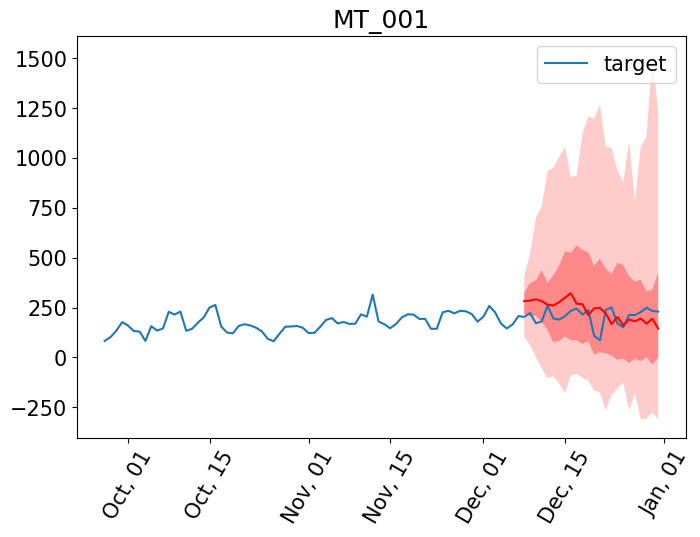

In [33]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(q_forecasts, q_tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='r')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [34]:
prediction_length

24

In [38]:
from gluonts.evaluation.metrics import mse, abs_error
import numpy as np

In [43]:
print("MSE:",mse(q_tss[0].values.reshape(-1)[-prediction_length:], np.median(q_forecasts[0].samples, axis=0)))

MSE: 5369.97


In [44]:
print("Mean Absolute Error:",abs_error(q_tss[0].values.reshape(-1)[-prediction_length:], np.median(q_forecasts[0].samples, axis=0))/ prediction_length)

Mean Absolute Error: 62.35084025065104
